In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme(style="whitegrid", rc={"figure.figsize": (10, 6)})

In [7]:
df = pd.read_parquet('../data/processed/m5_timeseries.parquet')
print(df.shape)
df.head()

(1530400, 22)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,dayofweek,weekofyear,month,year
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,None,None,0,0,0,NaN,5,4,1,2011
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,None,None,0,0,0,NaN,5,4,1,2011
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,None,None,0,0,0,NaN,5,4,1,2011
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,None,None,0,0,0,NaN,5,4,1,2011
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,None,None,0,0,0,NaN,5,4,1,2011


In [8]:
print(df['date'].min(), df['date'].max())
print(df['id'].nunique(), " Unique time series")
print(df.isnull().mean().sort_values(ascending=False).head(10))
print(df.duplicated(subset=['id', 'date']).sum())

2011-01-29 00:00:00 2016-04-24 00:00:00
800  Unique time series
sell_price    0.000005
id            0.000000
dept_id       0.000000
cat_id        0.000000
store_id      0.000000
item_id       0.000000
state_id      0.000000
d             0.000000
date          0.000000
sales         0.000000
dtype: float64
0


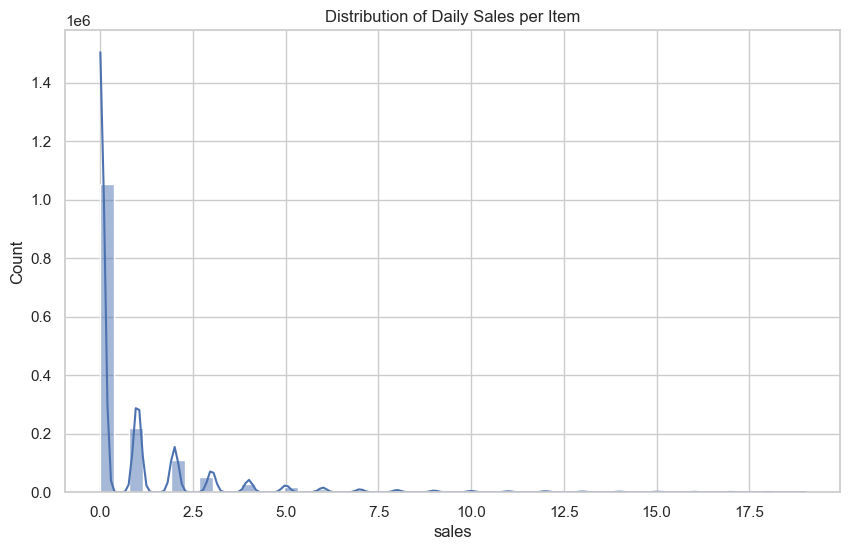

count    1.530400e+06
mean     8.821511e-01
std      2.623552e+00
min      0.000000e+00
50%      0.000000e+00
90%      2.000000e+00
95%      4.000000e+00
99%      1.100000e+01
max      2.940000e+02
Name: sales, dtype: float64


In [14]:
sns.histplot(df[df['sales'] < 20]['sales'], bins=50, kde=True)
plt.title("Distribution of Daily Sales per Item")
plt.show()

print(df['sales'].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

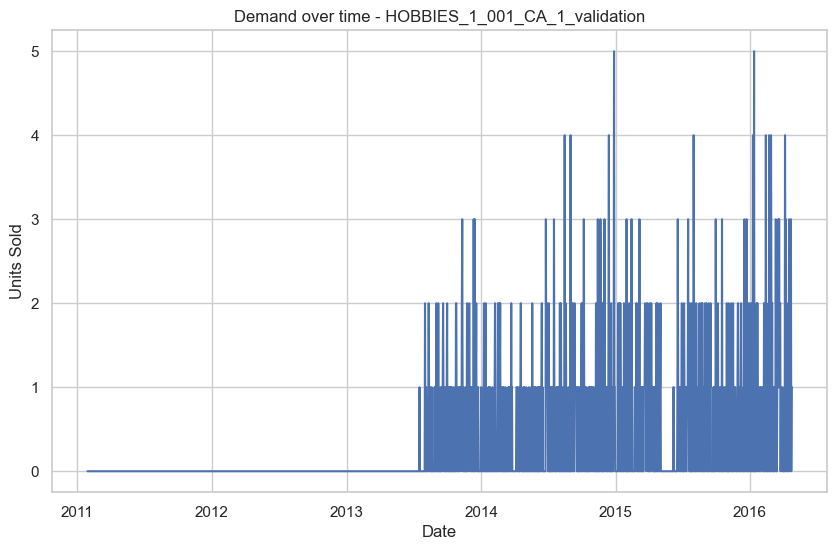

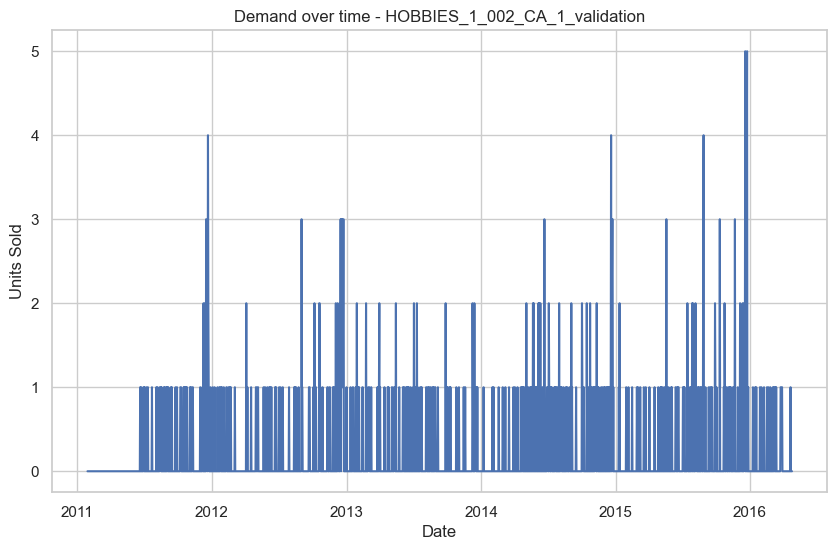

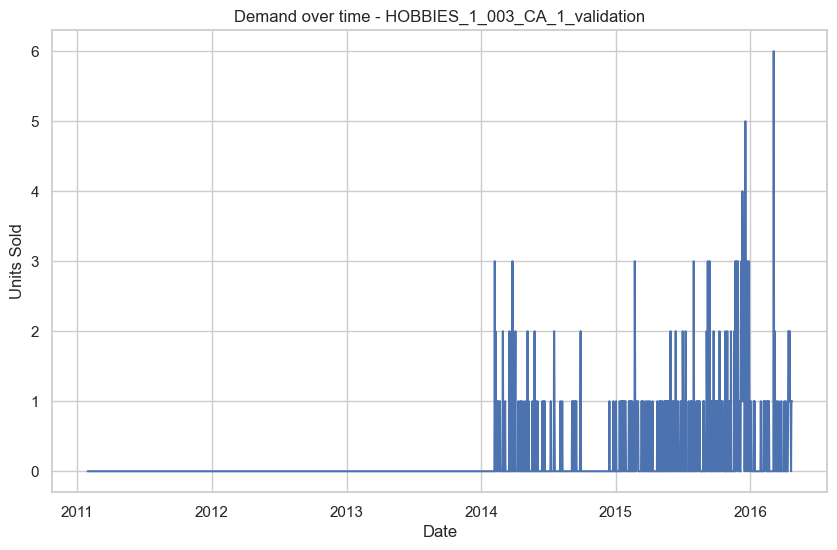

In [16]:
sample_ids = df['id'].unique()[:3]

for i in sample_ids:
    sku_df = df[df['id'] == i]
    plt.plot(sku_df['date'], sku_df['sales'])
    plt.title(f"Demand over time - {i}")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.show()

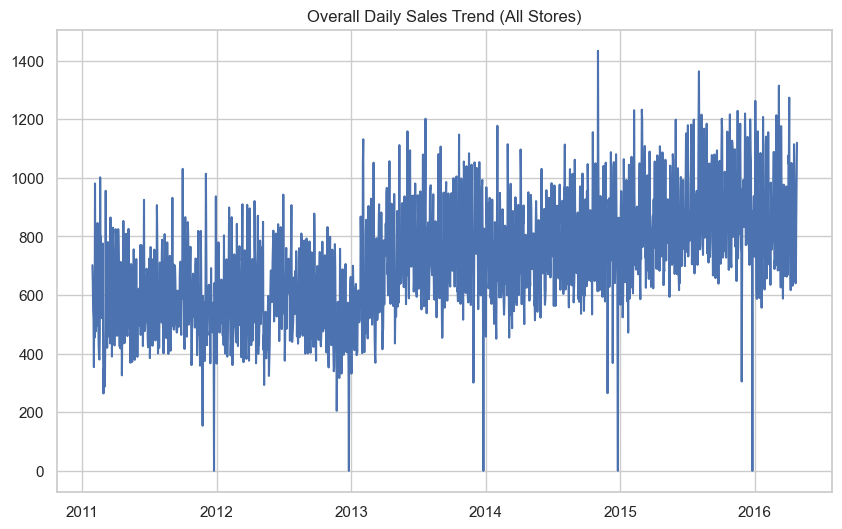

In [18]:
#Aggregate at higher levels
daily_sales = df.groupby('date')['sales'].sum().reset_index()
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Overall Daily Sales Trend (All Stores)")
plt.show()

# #Store-wise total sales
# store_sales = df.groupby('store_id')['sales'].sum().sort_values(ascending=False)
# store_sales.plot(kind='bar', title="Total Sales per Store")
# plt.ylabel("Total Units Sold")
# plt.show() -- only one store id CA

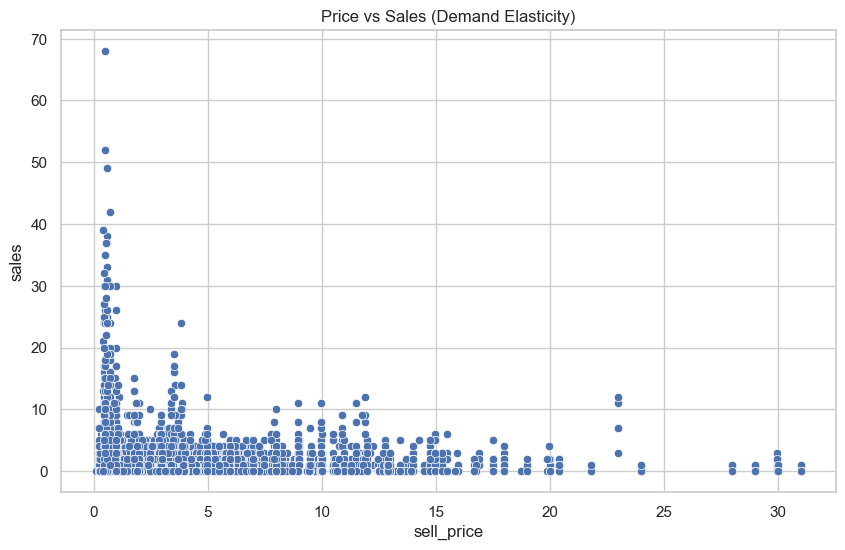

Correlation between price and sales: -0.106


In [22]:
#Price-Demand Relationship (Elasticity)
sample = df[df['sell_price'].notna()]
sns.scatterplot(x='sell_price', y='sales', data=sample.sample(10000))
plt.title("Price vs Sales (Demand Elasticity)")
plt.show()

#Correlation
corr = sample[['sell_price', 'sales']].corr().iloc[0,1]
print(f'Correlation between price and sales: {corr:.3f}')

Average sales on event days: 0.7980275974025974
Average sales on non-event days: 0.8895160602615122


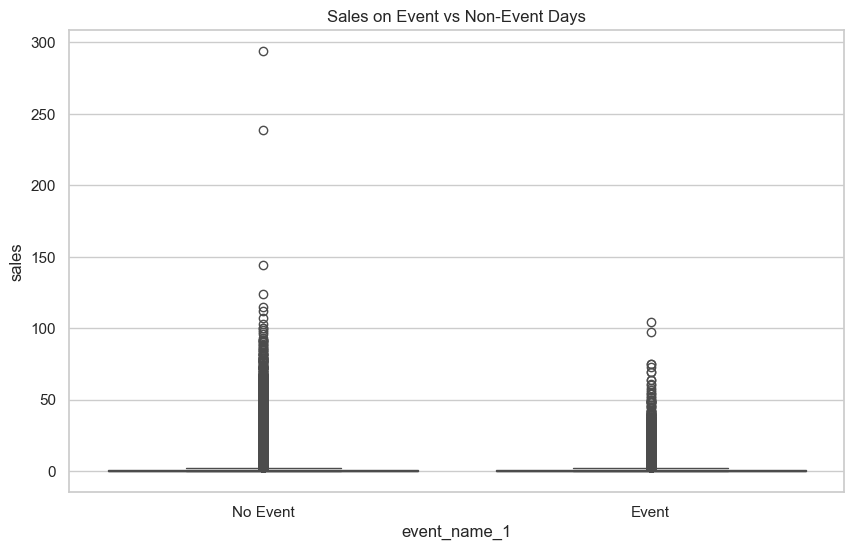

In [23]:
#Impact of Events & SNAP
#Comparing avrage sales on event vs not-event days
event_days = df[df['event_name_1'] != 'None']
non_event_days = df[df['event_name_1'] == 'None']

print("Average sales on event days:", event_days['sales'].mean())
print("Average sales on non-event days:", non_event_days['sales'].mean())

sns.boxplot(x=(df['event_name_1']!='None'), y='sales', data=df)
plt.title("Sales on Event vs Non-Event Days")
plt.xticks([0,1], ['No Event', 'Event'])
plt.show()

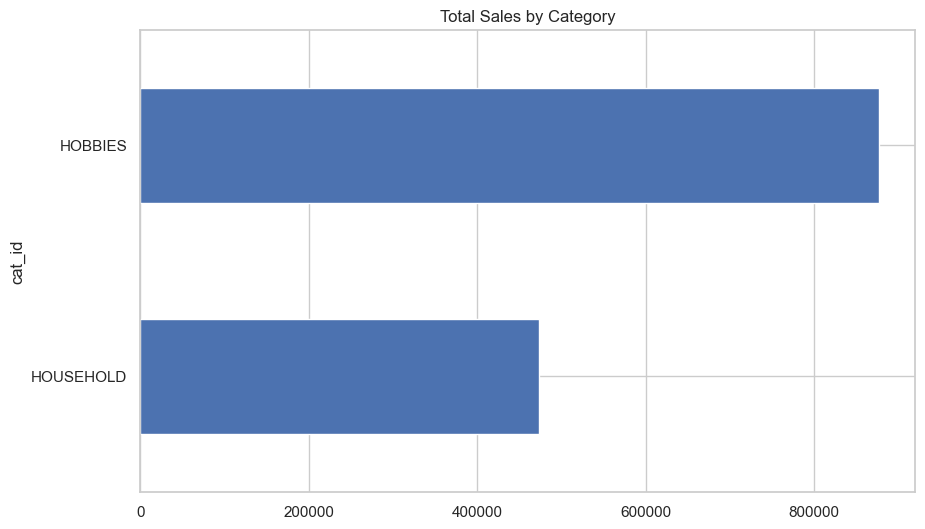

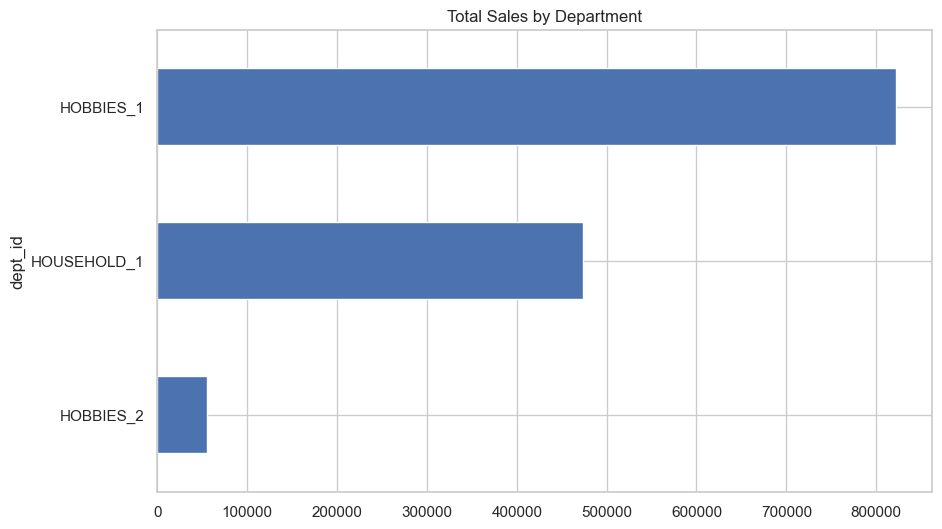

In [24]:
#Category and Store Variations
cat_sales = df.groupby('cat_id')['sales'].sum().sort_values()
cat_sales.plot(kind='barh', title='Total Sales by Category')
plt.show()

dept_sales = df.groupby('dept_id')['sales'].sum().sort_values()
dept_sales.plot(kind='barh', title='Total Sales by Department')
plt.show()

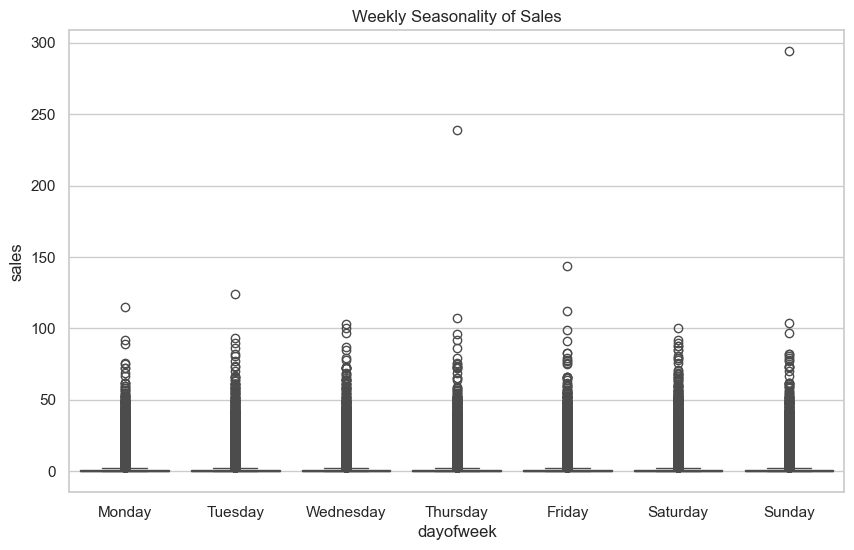

In [30]:
df['dayofweek'] = df['date'].dt.day_name()
sns.boxplot(x='dayofweek', y='sales', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Weekly Seasonality of Sales")
plt.show()

Outlier count: 14822


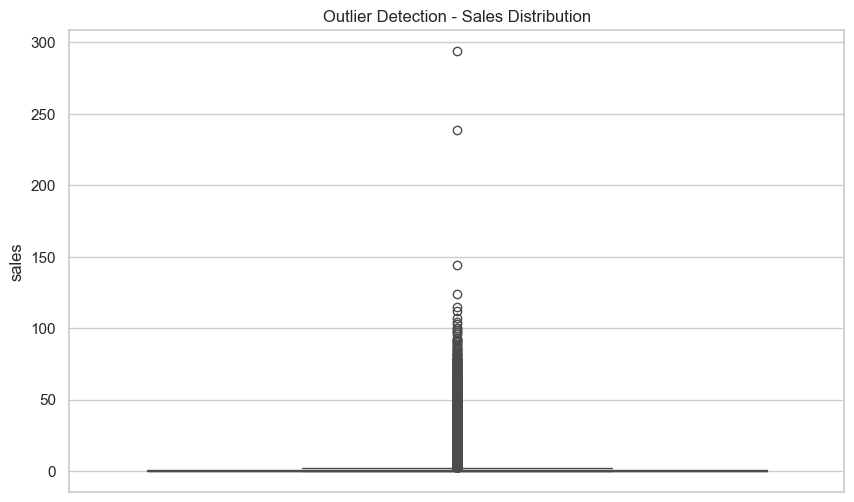

In [32]:
#Outliers and anomaly Detection
q_low = df['sales'].quantile(0.01)
q_high = df['sales'].quantile(0.99)
outliers = df[(df['sales'] < q_low) | (df['sales'] > q_high)]

print(f"Outlier count: {len(outliers)}")

sns.boxplot(df['sales'])
plt.title("Outlier Detection - Sales Distribution")
plt.show()

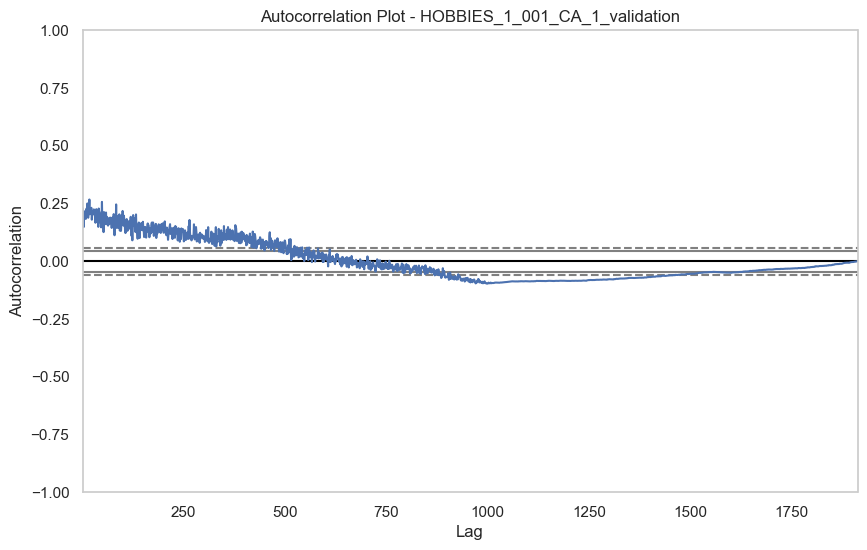

In [33]:
#AutoCorrelation
from pandas.plotting import autocorrelation_plot

sample_id = df['id'].iloc[0]
sku_df = df[df['id'] == sample_id]
autocorrelation_plot(sku_df['sales'])
plt.title(f"Autocorrelation Plot - {sample_id}")
plt.show()

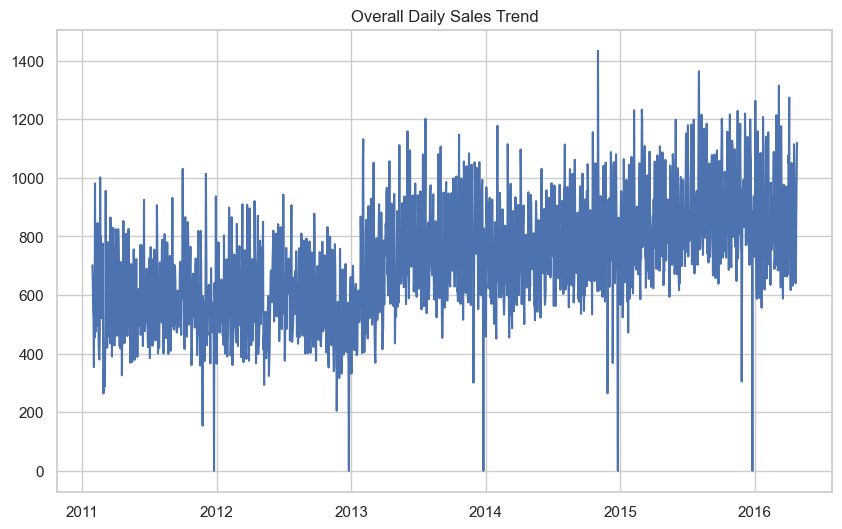

In [35]:
#Sales trend
plt.plot(df.groupby('date')['sales'].sum())
plt.title("Overall Daily Sales Trend")
plt.show()

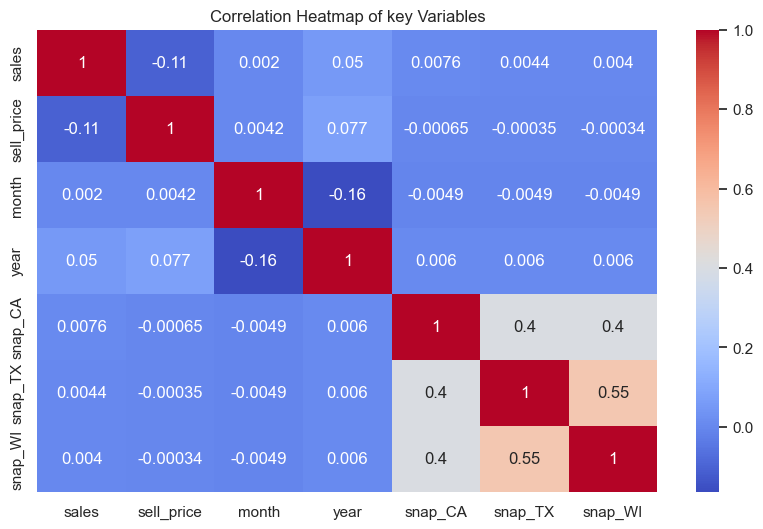

In [37]:
#Correlation of key variables
features = ['sales', 'sell_price', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of key Variables')
plt.show()